In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings 

import sys
sys.path.append("../")

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import particles.mcmc as mcmc
import particles.state_space_models as ssm
import particles.distributions as dists
from particles.core import SMC
from particles import smc_samplers as ssp
import seaborn
from tqdm import tqdm
import pickle
import os

from Utils import *

## Problem

The data are constituted of two independent counts of kangaroos population in New South Wales (Australia). Data are from Knape & De Valpine (2012). We aim to fit different population growth models on the historical data in order to predict the unobserved real population size from the countings.

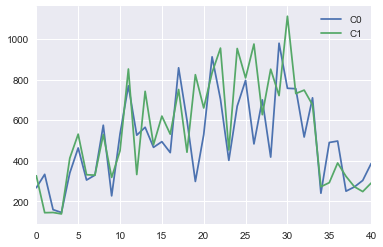

In [2]:
data[['C0','C1']].plot()

In [3]:
print(mean_N0, std_N0)

296.5 29.5


In [4]:
n_particles = 4000
n_iter = 20000

# Definition of a Logistic Diffusion State-Space Models

The `LogisticDiffusion` state-space model is a model with the following dynamic for the unobserved variable:

$$ \frac{dy_t}{y_t} = (r+\frac{\sigma^2}{2}-b\times y_t)dt + \sigma dW_t$$

In our experiments we are just going to discretize this equation as follow:

$$ log(y_{t+1}) = log(y_t) + (r+\frac{\sigma^2}{2}-b\times y_t)\Delta_t + \sigma N(0, \Delta_t) $$

If we implement the model considering $z_t = log(y_t)$, we simply get:

$$ z_{t+1} \sim N(z_t + (r+\frac{\sigma^2}{2}-b\times exp(z_t))\Delta_t, \Delta_t )$$ 

This is the transition distribution, for the emission distribution we simply use a negative binomial distribution with mean $y_t$ and variance $y_t + \tau y_t^2$.

In Knape & De Valpine (2012), three models are considered:
* Model 1: parameters are r, b, $\sigma$
* Model 2: b=0, parameters are r and $\sigma$
* Model 3: r=b=0, the only parameter is $\sigma$

We add a first simple model for the case where $\tau$ is also set to 0 (so the emission distribution because a Poisson of rate $y_t$).

## Tests with all models

### A Random Walk Model with Poisson emission distribution

In [6]:
prior_RWp = {'sigma': dists.Uniform(a=0.,b=10.)}
load_model = False

if load_model:
    pmmh_RWp = pickle.load(open( os.path.join(path,"RWp_model.pkl"), "rb" ))
else:
    p_RWp = dists.StructDist(prior_RWp)
    pmmh_RWp = mcmc.PMMH(ssm_cls=RandomWalk2D_poisson, prior=p_RWp, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_RWp.run()

In [168]:
print_metrics(pmmh_RWp)
plot_theta(prior_RWp, pmmh_RWp)

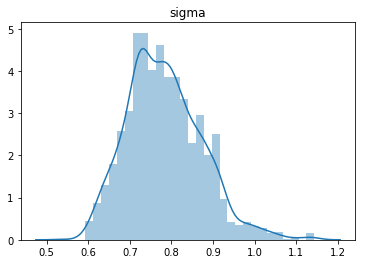

In [56]:
distplot(prior_RWp, pmmh_RWp, 250)

In [148]:
simulRWp = get_trajectories(N=100, start=500, model='poisson', pmmh=pmmh_RWp, n_particles=10000)

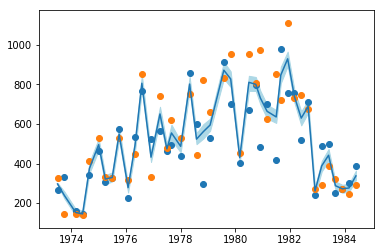

In [149]:
plot_posterior_trajectories(simulRWp)

## Random Walk Model (M3)

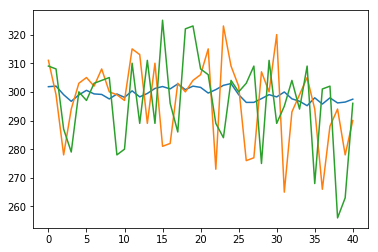

In [10]:
RW = RandomWalk2D(sigma=0.01,tau=0.0001)
simulate_plot(RW)

In [21]:
prior_RW = {'tau': dists.Uniform(a=0.,b=1.),'sigma': dists.Uniform(a=0.,b=10.)}
load_model = True

if load_model:
    pmmh_RW = pickle.load(open( os.path.join(path,"RW_model.pkl"), "rb" ))
else:
    p_RW = dists.StructDist(prior_RW)
    pmmh_RW= mcmc.PMMH(ssm_cls=RandomWalk2D, prior=p_RW, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_RW.run()
    # pickle.dump(pmmh_RW, open( os.path.join(path,"RW_model.pkl"), "wb" ) )

mean square jump distance: 133.93014469998243
posterior loglikelihood: [-536.81758867 -536.81758867 -536.81758867 -536.81758867 -536.81758867]
Acceptance rate: 0.35241762088104406
Last terms of theta chain: [(0.53149593, 0.05470937) (0.53149593, 0.05470937)
 (0.53149593, 0.05470937)]


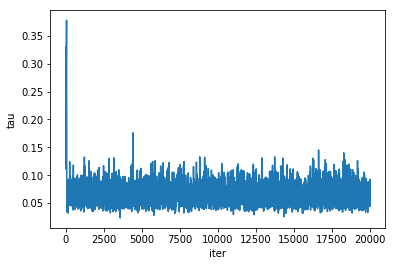

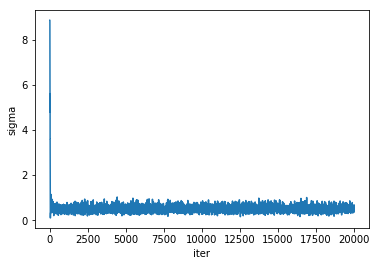

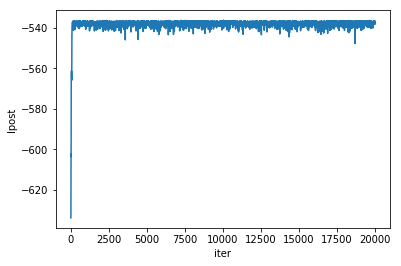

In [169]:
print_metrics(pmmh_RW)
plot_theta(prior_RW,pmmh_RW)

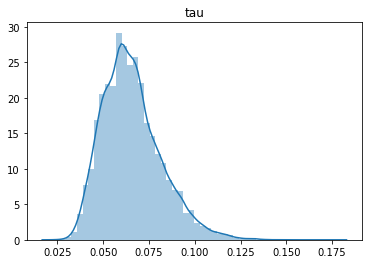

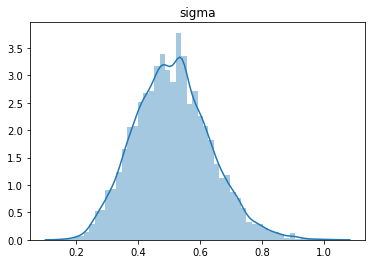

In [23]:
distplot(prior_RW, pmmh_RW, 500)

In [16]:
simulRW = get_trajectories(N=100, start=500, model='RW', pmmh=pmmh_RW, n_particles=10000)

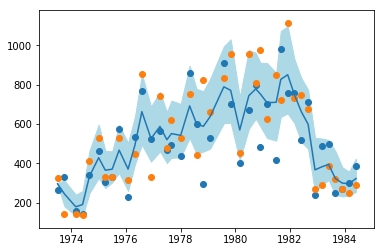

In [17]:
plot_posterior_trajectories(simulRW)

## Logistic Diffusion process with drift (M2)

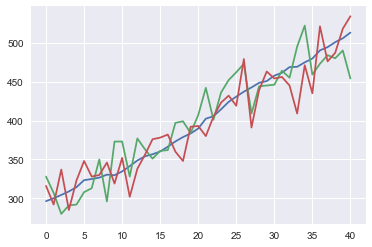

In [10]:
Ldrift = LDPDrift(sigma=0.01,tau=0.0001, r=0.05)
simulate_plot(Ldrift)

In [13]:
prior_Ldrift = {'tau': dists.Uniform(a=0.,b=1.),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}

load_model = False

if load_model:
    pmmh_Ldrift = pickle.load(open( os.path.join(path,"Ldrift_model.pkl"), "rb" ))
else:
    p_Ldrift = dists.StructDist(prior_Ldrift)
    pmmh_Ldrift= AdaptivePMMH(ssm_cls=LDPDrift, prior=p_Ldrift, data=y, Nx=n_particles, niter=50000, adaptive=True,
                              m1=4000, m2=20000, update_interv=500, w01=0.4, w02=0.5, w1=0.8, k0=5., k1=5.,
                              verbose=1000)
    pmmh_Ldrift.run()
    pickle.dump(pmmh_Ldrift, open( os.path.join(os.getcwd(),"Ldrift_model_adapt.pkl"), "wb" ) )

Iteration 0, r=-7.201, sigma=8.418, tau=0.030
Iteration 50, acc. rate=0.280, r=-6.962, sigma=8.289, tau=0.083
Iteration 100, acc. rate=0.320, r=-4.572, sigma=7.775, tau=0.039
Iteration 150, acc. rate=0.307, r=0.775, sigma=0.657, tau=0.092
Iteration 200, acc. rate=0.230, r=0.775, sigma=0.657, tau=0.092
Iteration 250, acc. rate=0.196, r=-0.142, sigma=0.623, tau=0.095
Iteration 300, acc. rate=0.163, r=-0.142, sigma=0.623, tau=0.095
Iteration 350, acc. rate=0.143, r=-0.168, sigma=0.518, tau=0.044
Iteration 400, acc. rate=0.128, r=-0.105, sigma=0.311, tau=0.135
Iteration 450, acc. rate=0.113, r=-0.105, sigma=0.311, tau=0.135
Iteration 500, acc. rate=0.104, r=0.293, sigma=0.423, tau=0.120
Iteration 550, acc. rate=0.096, r=0.347, sigma=0.567, tau=0.049
Iteration 600, acc. rate=0.088, r=0.347, sigma=0.567, tau=0.049
Iteration 650, acc. rate=0.082, r=0.347, sigma=0.567, tau=0.049
Iteration 700, acc. rate=0.080, r=-0.250, sigma=0.396, tau=0.061
Iteration 750, acc. rate=0.076, r=-0.183, sigma=0.6

Iteration 6300, acc. rate=0.118, r=0.036, sigma=0.815, tau=0.037
Iteration 6350, acc. rate=0.119, r=0.113, sigma=0.583, tau=0.069
Iteration 6400, acc. rate=0.121, r=0.369, sigma=0.575, tau=0.061
Iteration 6450, acc. rate=0.122, r=0.059, sigma=0.421, tau=0.077
Iteration 6500, acc. rate=0.122, r=-0.408, sigma=0.669, tau=0.040
Iteration 6550, acc. rate=0.123, r=0.016, sigma=0.482, tau=0.044
Iteration 6600, acc. rate=0.124, r=0.111, sigma=0.487, tau=0.048
Iteration 6650, acc. rate=0.125, r=0.131, sigma=0.575, tau=0.085
Iteration 6700, acc. rate=0.126, r=-0.059, sigma=0.518, tau=0.083
Iteration 6750, acc. rate=0.127, r=-0.026, sigma=0.650, tau=0.041
Iteration 6800, acc. rate=0.129, r=-0.039, sigma=0.570, tau=0.049
Iteration 6850, acc. rate=0.131, r=0.145, sigma=0.441, tau=0.071
Iteration 6900, acc. rate=0.131, r=-0.075, sigma=0.469, tau=0.065
Iteration 6950, acc. rate=0.133, r=0.002, sigma=0.502, tau=0.054
Iteration 7000, acc. rate=0.133, r=-0.023, sigma=0.627, tau=0.045
Iteration 7050, acc

Iteration 12550, acc. rate=0.187, r=0.056, sigma=0.581, tau=0.046
Iteration 12600, acc. rate=0.187, r=0.184, sigma=0.801, tau=0.058
Iteration 12650, acc. rate=0.188, r=0.118, sigma=0.468, tau=0.063
Iteration 12700, acc. rate=0.188, r=-0.056, sigma=0.344, tau=0.079
Iteration 12750, acc. rate=0.188, r=0.225, sigma=0.659, tau=0.055
Iteration 12800, acc. rate=0.188, r=-0.123, sigma=0.602, tau=0.071
Iteration 12850, acc. rate=0.188, r=0.004, sigma=0.737, tau=0.073
Iteration 12900, acc. rate=0.188, r=0.173, sigma=0.451, tau=0.041
Iteration 12950, acc. rate=0.189, r=0.249, sigma=0.948, tau=0.091
Iteration 13000, acc. rate=0.190, r=0.211, sigma=0.535, tau=0.047
Iteration 13050, acc. rate=0.190, r=-0.002, sigma=0.533, tau=0.042
Iteration 13100, acc. rate=0.190, r=0.344, sigma=0.790, tau=0.048
Iteration 13150, acc. rate=0.191, r=0.408, sigma=0.758, tau=0.042
Iteration 13200, acc. rate=0.191, r=-0.053, sigma=0.610, tau=0.051
Iteration 13250, acc. rate=0.191, r=0.061, sigma=0.572, tau=0.057
Iterat

Iteration 18750, acc. rate=0.210, r=0.028, sigma=0.536, tau=0.049
Iteration 18800, acc. rate=0.210, r=-0.076, sigma=0.513, tau=0.076
Iteration 18850, acc. rate=0.210, r=0.094, sigma=0.405, tau=0.079
Iteration 18900, acc. rate=0.210, r=-0.029, sigma=0.316, tau=0.080
Iteration 18950, acc. rate=0.210, r=-0.169, sigma=0.576, tau=0.061
Iteration 19000, acc. rate=0.210, r=0.158, sigma=0.844, tau=0.079
Iteration 19050, acc. rate=0.211, r=0.119, sigma=0.766, tau=0.037
Iteration 19100, acc. rate=0.211, r=-0.012, sigma=0.633, tau=0.054
Iteration 19150, acc. rate=0.211, r=-0.086, sigma=0.636, tau=0.051
Iteration 19200, acc. rate=0.212, r=-0.389, sigma=0.764, tau=0.031
Iteration 19250, acc. rate=0.212, r=-0.106, sigma=0.447, tau=0.061
Iteration 19300, acc. rate=0.212, r=-0.015, sigma=0.491, tau=0.078
Iteration 19350, acc. rate=0.212, r=0.130, sigma=0.416, tau=0.083
Iteration 19400, acc. rate=0.212, r=-0.111, sigma=0.322, tau=0.081
Iteration 19450, acc. rate=0.212, r=-0.260, sigma=0.454, tau=0.054


Iteration 24950, acc. rate=0.233, r=0.040, sigma=0.557, tau=0.063
Iteration 25000, acc. rate=0.233, r=0.001, sigma=0.429, tau=0.101
Iteration 25050, acc. rate=0.233, r=0.019, sigma=0.504, tau=0.074
Iteration 25100, acc. rate=0.233, r=0.159, sigma=0.457, tau=0.056
Iteration 25150, acc. rate=0.233, r=0.104, sigma=0.545, tau=0.058
Iteration 25200, acc. rate=0.234, r=-0.153, sigma=0.552, tau=0.064
Iteration 25250, acc. rate=0.234, r=-0.169, sigma=0.599, tau=0.057
Iteration 25300, acc. rate=0.234, r=-0.271, sigma=0.573, tau=0.059
Iteration 25350, acc. rate=0.234, r=-0.170, sigma=0.671, tau=0.052
Iteration 25400, acc. rate=0.234, r=0.026, sigma=0.389, tau=0.057
Iteration 25450, acc. rate=0.234, r=-0.124, sigma=0.456, tau=0.063
Iteration 25500, acc. rate=0.234, r=0.086, sigma=0.403, tau=0.075
Iteration 25550, acc. rate=0.234, r=-0.049, sigma=0.536, tau=0.061
Iteration 25600, acc. rate=0.234, r=-0.129, sigma=0.406, tau=0.069
Iteration 25650, acc. rate=0.235, r=-0.306, sigma=0.489, tau=0.060
It

Iteration 31150, acc. rate=0.244, r=0.228, sigma=0.669, tau=0.049
Iteration 31200, acc. rate=0.245, r=-0.089, sigma=0.535, tau=0.052
Iteration 31250, acc. rate=0.245, r=0.134, sigma=0.549, tau=0.048
Iteration 31300, acc. rate=0.245, r=0.076, sigma=0.827, tau=0.041
Iteration 31350, acc. rate=0.245, r=-0.039, sigma=0.580, tau=0.061
Iteration 31400, acc. rate=0.245, r=0.061, sigma=0.682, tau=0.042
Iteration 31450, acc. rate=0.245, r=0.036, sigma=0.693, tau=0.051
Iteration 31500, acc. rate=0.245, r=0.171, sigma=0.521, tau=0.060
Iteration 31550, acc. rate=0.245, r=0.001, sigma=0.474, tau=0.074
Iteration 31600, acc. rate=0.245, r=-0.205, sigma=0.636, tau=0.069
Iteration 31650, acc. rate=0.245, r=0.037, sigma=0.439, tau=0.041
Iteration 31700, acc. rate=0.245, r=0.067, sigma=0.646, tau=0.046
Iteration 31750, acc. rate=0.246, r=-0.079, sigma=0.397, tau=0.071
Iteration 31800, acc. rate=0.246, r=-0.102, sigma=0.496, tau=0.068
Iteration 31850, acc. rate=0.246, r=-0.198, sigma=0.653, tau=0.057
Iter

Iteration 37350, acc. rate=0.257, r=0.135, sigma=0.619, tau=0.065
Iteration 37400, acc. rate=0.257, r=-0.053, sigma=0.564, tau=0.069
Iteration 37450, acc. rate=0.257, r=0.376, sigma=0.802, tau=0.048
Iteration 37500, acc. rate=0.257, r=0.218, sigma=0.384, tau=0.126
Iteration 37550, acc. rate=0.257, r=0.118, sigma=0.262, tau=0.111
Iteration 37600, acc. rate=0.257, r=0.231, sigma=0.389, tau=0.069
Iteration 37650, acc. rate=0.257, r=0.074, sigma=0.321, tau=0.104
Iteration 37700, acc. rate=0.257, r=0.065, sigma=0.761, tau=0.051
Iteration 37750, acc. rate=0.258, r=-0.102, sigma=0.530, tau=0.060
Iteration 37800, acc. rate=0.257, r=0.164, sigma=0.280, tau=0.084
Iteration 37850, acc. rate=0.258, r=-0.002, sigma=0.640, tau=0.040
Iteration 37900, acc. rate=0.258, r=0.187, sigma=0.455, tau=0.084
Iteration 37950, acc. rate=0.258, r=-0.037, sigma=0.322, tau=0.082
Iteration 38000, acc. rate=0.258, r=0.017, sigma=0.660, tau=0.050
Iteration 38050, acc. rate=0.258, r=0.166, sigma=0.517, tau=0.051
Iterat

Iteration 43550, acc. rate=0.264, r=0.033, sigma=0.431, tau=0.048
Iteration 43600, acc. rate=0.264, r=-0.097, sigma=0.545, tau=0.052
Iteration 43650, acc. rate=0.264, r=0.135, sigma=0.288, tau=0.087
Iteration 43700, acc. rate=0.264, r=-0.019, sigma=0.547, tau=0.085
Iteration 43750, acc. rate=0.264, r=-0.088, sigma=0.575, tau=0.030
Iteration 43800, acc. rate=0.264, r=-0.031, sigma=0.231, tau=0.089
Iteration 43850, acc. rate=0.264, r=-0.096, sigma=0.618, tau=0.070
Iteration 43900, acc. rate=0.264, r=-0.018, sigma=0.562, tau=0.076
Iteration 43950, acc. rate=0.264, r=0.046, sigma=0.650, tau=0.050
Iteration 44000, acc. rate=0.264, r=-0.047, sigma=0.637, tau=0.085
Iteration 44050, acc. rate=0.264, r=0.167, sigma=0.448, tau=0.057
Iteration 44100, acc. rate=0.265, r=-0.052, sigma=0.557, tau=0.073
Iteration 44150, acc. rate=0.265, r=0.294, sigma=0.475, tau=0.053
Iteration 44200, acc. rate=0.265, r=-0.064, sigma=0.582, tau=0.059
Iteration 44250, acc. rate=0.265, r=0.195, sigma=0.546, tau=0.078
I

Iteration 49750, acc. rate=0.270, r=-0.094, sigma=0.648, tau=0.040
Iteration 49800, acc. rate=0.270, r=0.218, sigma=0.702, tau=0.068
Iteration 49850, acc. rate=0.270, r=-0.021, sigma=0.480, tau=0.066
Iteration 49900, acc. rate=0.270, r=-0.094, sigma=0.552, tau=0.065
Iteration 49950, acc. rate=0.270, r=0.070, sigma=0.619, tau=0.067


mean square jump distance: 242.54698749308335
posterior loglikelihood: [-539.94452765 -539.94452765 -539.94452765 -539.94452765 -539.94452765]
Acceptance rate: 0.30756537826891345
Last terms of theta chain: [(0.0299779, 0.52289305, 0.06859551) (0.0299779, 0.52289305, 0.06859551)
 (0.0299779, 0.52289305, 0.06859551)]


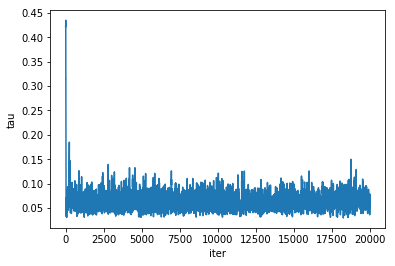

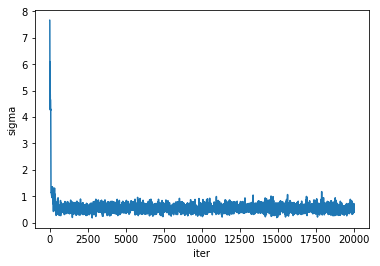

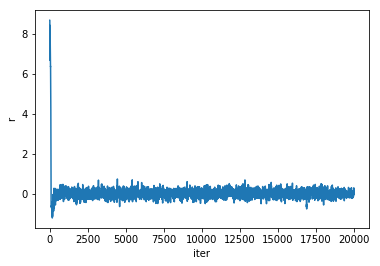

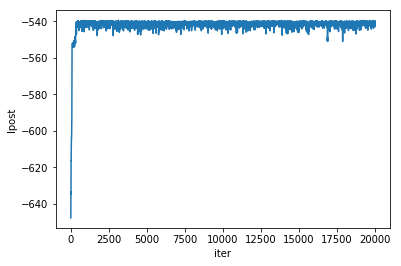

In [170]:
print_metrics(pmmh_Ldrift)
plot_theta(prior_Ldrift,pmmh_Ldrift)

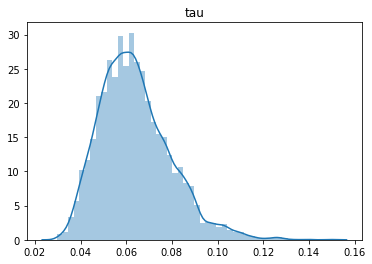

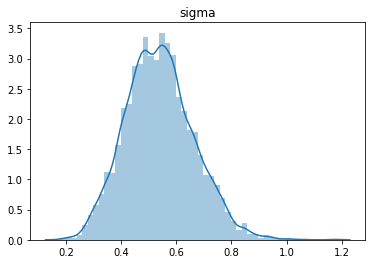

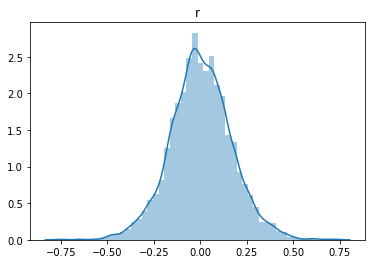

In [31]:
distplot(prior_Ldrift,pmmh_Ldrift,1000)

In [32]:
simulLDrift = get_trajectories(N=100, start=500, model='LDrift', pmmh=pmmh_Ldrift, n_particles=10000)

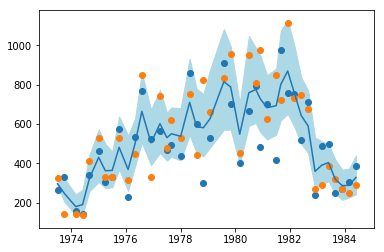

In [33]:
plot_posterior_trajectories(simulLDrift)

## Logistic Diffusion process with drift and restoring force: No Euler discretization

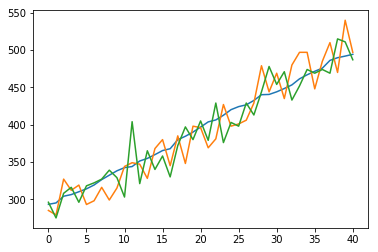

In [23]:
LD = LogisticDiffusion2D(sigma=0.01,k=0.0001, r=0.005, b=1e-6)
simulate_plot(Ldrift)

In [47]:
prior_LD = {'tau': dists.Uniform(a=0.,b=1.), 'b': dists.Uniform(a=0., b=1e-2),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}
load_model = True

if load_model:
    pmmh_LD = pickle.load(open( os.path.join(path,"LD_model.pkl"), "rb" ))
else:
    p_LD = dists.StructDist(prior_LD)
    pmmh_LD= mcmc.PMMH(ssm_cls=LogisticDiffusion2D, prior=p_LD, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_LD.run()
    # pickle.dump(pmmh_LD, open( os.path.join(path,"LD_model.pkl"), "wb" ) )

mean square jump distance: 238.1571313016029
posterior loglikelihood: [-541.20994155]
Acceptance rate: 0.24746237311865593
Last terms of theta chain: [(0.00049763, 0.08628207, -0.10844376, 0.38487874)
 (0.00049763, 0.08628207, -0.10844376, 0.38487874)
 (0.00049763, 0.08628207, -0.10844376, 0.38487874)]


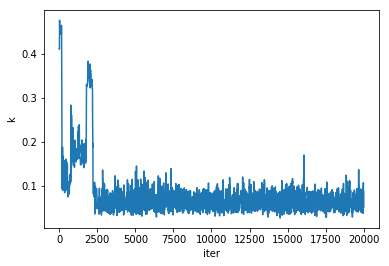

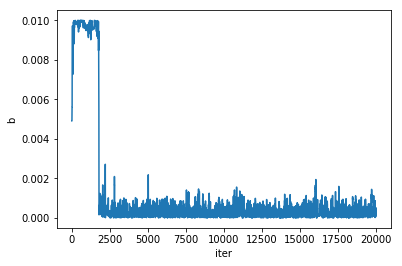

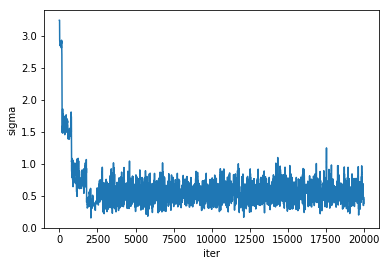

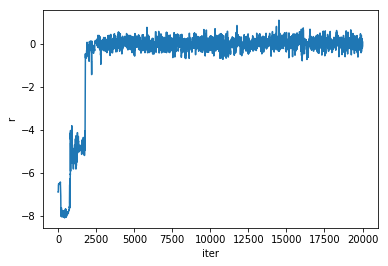

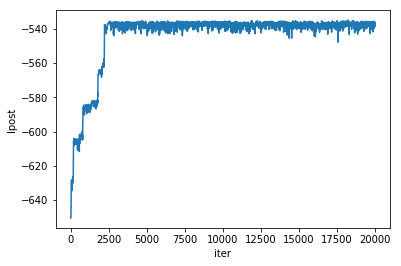

In [48]:
print_metrics(pmmh_LD)
plot_theta(prior_LD,pmmh_LD)

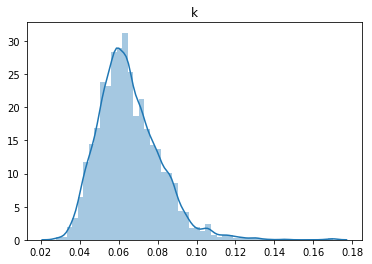

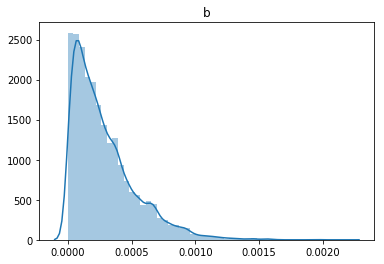

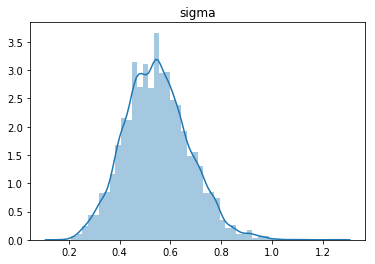

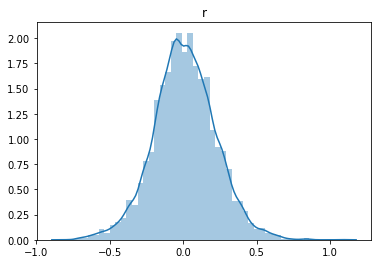

In [49]:
distplot(prior_LD,pmmh_LD, 5000)

In [176]:
simulLD = get_trajectories(N=100, start=2500, model='LD', pmmh=pmmh_LD, n_particles=10000)

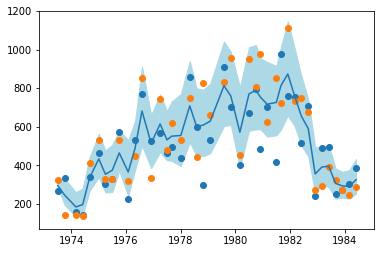

In [177]:
plot_posterior_trajectories(simulLD)

## Logistic Diffusion process with Euler Discretization (M1)

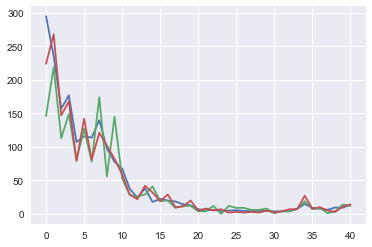

In [5]:
my_ssm = LDEuler(r=0.005, b=0.003, sigma=0.6, tau=0.06)
simulate_plot(my_ssm)

In [6]:
prior_LDEuler = {'tau': dists.Uniform(a=0.,b=1.), 'b': dists.Uniform(a=0., b=10.),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}
load_model = False

if load_model:
    pmmh_LD = pickle.load(open( os.path.join(path,"LDEuler_model.pkl"), "rb" ))
else:
    p_LDEuler = dists.StructDist(prior_LDEuler)
    pmmh_LDEuler= AdaptivePMMH(ssm_cls=LDEuler, prior=p_LDEuler, data=y, Nx=n_particles, niter=50000, adaptive=True,
                              m1=4000, m2=20000, update_interv=500, w01=0.4, w02=0.5, w1=0.8, k0=5., k1=5.,
                              verbose=1000)
    pmmh_LDEuler.run()
    pickle.dump(pmmh_LDEuler, open( os.path.join(os.getcwd(),"LDEuler_model_adapt.pkl"), "wb" ) )

Iteration 0, b=2.500, r=-2.069, sigma=9.167, tau=0.488
Iteration 50, acc. rate=0.080, b=2.226, r=-1.954, sigma=8.864, tau=0.462
Iteration 100, acc. rate=0.040, b=2.226, r=-1.954, sigma=8.864, tau=0.462
Iteration 150, acc. rate=0.060, b=1.808, r=-2.426, sigma=8.474, tau=0.996
Iteration 200, acc. rate=0.045, b=1.808, r=-2.426, sigma=8.474, tau=0.996
Iteration 250, acc. rate=0.044, b=0.619, r=-2.729, sigma=8.345, tau=0.880
Iteration 300, acc. rate=0.040, b=0.104, r=-3.149, sigma=8.084, tau=0.670
Iteration 350, acc. rate=0.040, b=0.020, r=-3.241, sigma=8.046, tau=0.787
Iteration 400, acc. rate=0.035, b=0.020, r=-3.241, sigma=8.046, tau=0.787
Iteration 450, acc. rate=0.031, b=0.020, r=-3.241, sigma=8.046, tau=0.787
Iteration 500, acc. rate=0.028, b=0.020, r=-3.241, sigma=8.046, tau=0.787
Iteration 550, acc. rate=0.025, b=0.020, r=-3.241, sigma=8.046, tau=0.787
Iteration 600, acc. rate=0.023, b=0.020, r=-3.241, sigma=8.046, tau=0.787
Iteration 650, acc. rate=0.022, b=0.020, r=-3.241, sigma=8

Iteration 5500, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 5550, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 5600, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 5650, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 5700, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 5750, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 5800, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 5850, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 5900, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 5950, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 6000, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 6050, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 6100, acc. rate=0.003, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 6150, acc. rate

Iteration 10950, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11000, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11050, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11100, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11150, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11200, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11250, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11300, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11350, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11400, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11450, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11500, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11550, acc. rate=0.002, b=0.012, r=-3.229, sigma=8.018, tau=0.487
Iteration 11

Iteration 16350, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16400, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16450, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16500, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16550, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16600, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16650, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16700, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16750, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16800, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16850, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16900, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 16950, acc. rate=0.001, b=0.037, r=-3.186, sigma=8.052, tau=0.643
Iteration 17

Iteration 21750, acc. rate=0.001, b=0.028, r=-3.251, sigma=8.050, tau=0.811
Iteration 21800, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 21850, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 21900, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 21950, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 22000, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 22050, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 22100, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 22150, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 22200, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 22250, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 22300, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 22350, acc. rate=0.001, b=0.019, r=-3.240, sigma=8.046, tau=0.784
Iteration 22

Iteration 27150, acc. rate=0.001, b=0.014, r=-3.234, sigma=8.044, tau=0.770
Iteration 27200, acc. rate=0.001, b=0.014, r=-3.234, sigma=8.044, tau=0.770
Iteration 27250, acc. rate=0.001, b=0.014, r=-3.234, sigma=8.044, tau=0.770
Iteration 27300, acc. rate=0.001, b=0.014, r=-3.234, sigma=8.044, tau=0.770
Iteration 27350, acc. rate=0.001, b=0.014, r=-3.234, sigma=8.044, tau=0.770
Iteration 27400, acc. rate=0.001, b=0.014, r=-3.234, sigma=8.044, tau=0.770
Iteration 27450, acc. rate=0.001, b=0.023, r=-2.968, sigma=7.663, tau=0.766
Iteration 27500, acc. rate=0.001, b=0.023, r=-2.968, sigma=7.663, tau=0.766
Iteration 27550, acc. rate=0.001, b=0.023, r=-2.968, sigma=7.663, tau=0.766
Iteration 27600, acc. rate=0.001, b=0.023, r=-2.968, sigma=7.663, tau=0.766
Iteration 27650, acc. rate=0.001, b=0.023, r=-2.968, sigma=7.663, tau=0.766
Iteration 27700, acc. rate=0.001, b=0.023, r=-2.968, sigma=7.663, tau=0.766
Iteration 27750, acc. rate=0.001, b=0.023, r=-2.968, sigma=7.663, tau=0.766
Iteration 27

Iteration 32550, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 32600, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 32650, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 32700, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 32750, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 32800, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 32850, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 32900, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 32950, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 33000, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 33050, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 33100, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 33150, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 33

Iteration 37950, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38000, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38050, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38100, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38150, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38200, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38250, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38300, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38350, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38400, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38450, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38500, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38550, acc. rate=0.001, b=0.022, r=-2.967, sigma=7.663, tau=0.761
Iteration 38

Iteration 43350, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43400, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43450, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43500, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43550, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43600, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43650, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43700, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43750, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43800, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43850, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43900, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 43950, acc. rate=0.001, b=0.027, r=-2.981, sigma=7.660, tau=0.875
Iteration 44

Iteration 48750, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 48800, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 48850, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 48900, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 48950, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 49000, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 49050, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 49100, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 49150, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 49200, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 49250, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 49300, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 49350, acc. rate=0.001, b=0.043, r=-3.269, sigma=8.055, tau=0.852
Iteration 49

In [12]:
print_metrics(pmmh_LDEuler)
plot_theta(prior_LDEuler,pmmh_LDEuler)

AttributeError: 'AdaptivePMMH' object has no attribute 'prop'

In [15]:
simulLDEuler = get_trajectories(N=100, start=500, model='LDEuler', pmmh=pmmh_LDEuler, n_particles=10000)

ValueError: no field of name b

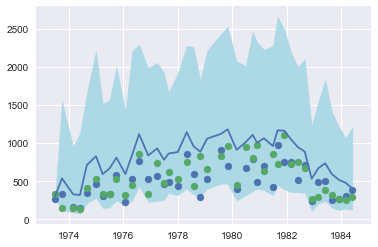

In [9]:
plot_posterior_trajectories(simulLDEuler)

# Test with new Adaptation method

## Random Walk model

In [11]:
prior_RW = {'tau': dists.Uniform(a=0.,b=1.),'sigma': dists.Uniform(a=0.,b=10.)}
load_model = False

if load_model:
    pmmh_RW = pickle.load(open( os.path.join(path,"RW_model_Adapt.pkl"), "rb" ))
else:
    p_RW = dists.StructDist(prior_RW)
    new_pmmh_RW= AdaptivePMMH(ssm_cls=RandomWalk2D, prior=p_RW, data=y, Nx=n_particles, niter=10000, adaptive=True,
                              m1=400, m2=2000, update_interv=100, w01=0.4, w02=0.5, w1=0.8, k0=5., k1=5.,
                              verbose=100, EM=True)
    new_pmmh_RW.run()
    # pickle.dump(new_pmmh_RW, open( os.path.join(path,"RW_model_Adapt.pkl"), "wb" ) )

Iteration 0, sigma=0.955, tau=0.314
Iteration 100, acc. rate=0.160, sigma=0.298, tau=0.079
Iteration 200, acc. rate=0.120, sigma=0.554, tau=0.046
Iteration 300, acc. rate=0.097, sigma=0.342, tau=0.074
Iteration 400, acc. rate=0.105, sigma=0.480, tau=0.047
Iteration 500, acc. rate=0.194, sigma=0.404, tau=0.098
Iteration 600, acc. rate=0.262, sigma=0.502, tau=0.054
Iteration 700, acc. rate=0.297, sigma=0.879, tau=0.054
Iteration 800, acc. rate=0.330, sigma=0.296, tau=0.081
Iteration 900, acc. rate=0.350, sigma=0.411, tau=0.095
Iteration 1000, acc. rate=0.359, sigma=0.510, tau=0.063
Iteration 1100, acc. rate=0.360, sigma=0.692, tau=0.047
Iteration 1200, acc. rate=0.360, sigma=0.596, tau=0.063
Iteration 1300, acc. rate=0.371, sigma=0.458, tau=0.062
Iteration 1400, acc. rate=0.378, sigma=0.550, tau=0.068
Iteration 1500, acc. rate=0.390, sigma=0.594, tau=0.042
Iteration 1600, acc. rate=0.393, sigma=0.659, tau=0.066
Iteration 1700, acc. rate=0.398, sigma=0.463, tau=0.068
Iteration 1800, acc. 

mean square jump distance: 155.43527462404566
posterior loglikelihood: [-537.50385657 -537.12185931 -537.12185931 -539.35860108 -537.14185733]
Acceptance rate: 0.43954395439543953
Last terms of theta chain: [(0.48237633, 0.05110612) (0.37531602, 0.1056856 )
 (0.56046709, 0.06435828)]


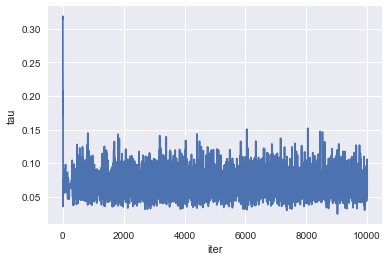

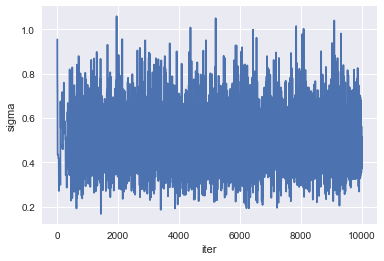

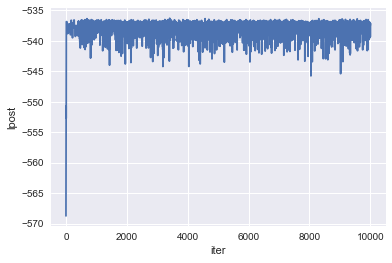

In [12]:
print_metrics(new_pmmh_RW)
plot_theta(prior_RW,new_pmmh_RW)

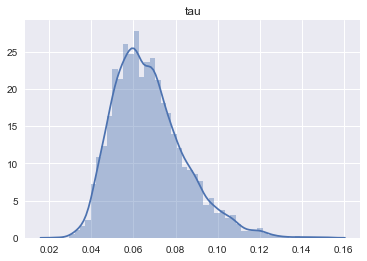

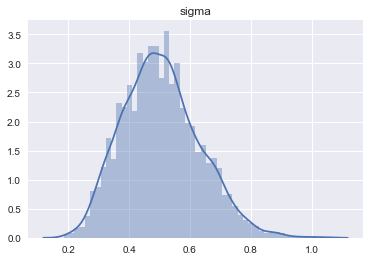

In [13]:
distplot(prior_RW, new_pmmh_RW, 2000)

In [14]:
simul_post = get_trajectories(N=100, start=2000, model='RW', pmmh=new_pmmh_RW, n_particles=10000)

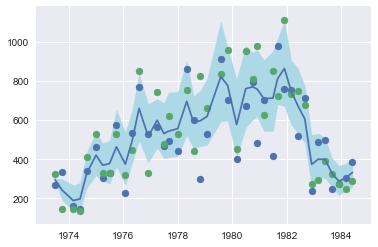

In [15]:
plot_posterior_trajectories(simul_post)

In [18]:
pickle.dump(new_pmmh_RW, open( os.path.join(os.getcwd(),"RW_model_Adapt.pkl"), "wb" ) )

# Further work

## Guided PF

The main task when working with guided PF is the choice of the guide distribution. A definition of an optimal guide is provided in the lecture, but its exact computation is not tractable in our case. We first look if a Gaussian distribution could be a good approximation for the negative binomial distribution with a simple example similar to our problem.

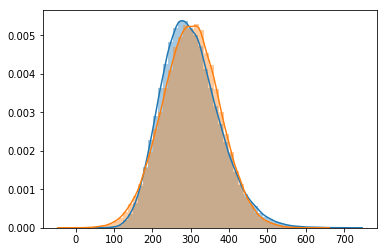

In [46]:
L=[]
K=[]
for i in range(100000):
    L.append(dists.NegativeBinomial(n=1/0.06, p=1/(1+0.06*300)).rvs()[0])
    K.append(dists.Normal(loc=300., scale=np.sqrt(300*(1+0.06*300))).rvs())
seaborn.distplot(L)
seaborn.distplot(K)